In [1]:
import numpy as np
import pandas as pd

import re
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression, RidgeClassifier, SGDClassifier
import lightgbm
import xgboost
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

SEED = 1

In [2]:
#Read the data
dataset = pd.read_csv('OldData_and_newData.csv', usecols=['id', 'article','label'])

In [3]:
#Get shape
dataset.shape

(1272, 3)

In [4]:
dataset.head()

,id,article,label
0,10909,article 7. - le conseil des professeurs il est...,Not Zone
1,571,article 3. — les ouvrages ou installations son...,Not Zone
2,10509,article l. 365-1. - la responsabilité civile o...,Not Zone
3,2572,article 23. le conseil d'administration ne peu...,Not Zone
4,36,article 14. - sur la base du compte rendu de r...,Not Zone


In [68]:
dataset.iloc[700]['article']

"article 51. l'alinéa suivant est ajouté à l'article $13 du code judiciaire tel que modifié par la loi du 6 avril 1992 : « les huissiers de justice ayant leurs offices dans les circuits judiciaires d'anvers, de bruges et de furnes sont compétents pour agir sur la mer territoriale visée. dans l'article | de la loi du 6 octobre 1987 fixant la largeur de la mer territoriale de la belgique et dans la zone économique exclusive visée à l'article 2 de la loi du 22 avril 1999 relative à la zone économique exclusive de la belgique en mer du nord."

In [5]:
label_0 = dataset[dataset['label']=='Not Zone'].value_counts()
print(label_0.shape)

label_1 = dataset[dataset['label']=='Zone'].value_counts()
print(label_1.shape)

(636,)
(636,)


In [6]:
data = dataset.groupby('label', group_keys=False).apply(lambda x: x.sample(dataset.label.value_counts().min()))
data.shape

(1272, 3)

In [8]:
label_0 = data[data['label']=='Not Zone'].value_counts()
print(label_0.shape)

label_1 = data[data['label']=='Zone'].value_counts()
print(label_1.shape)

(636,)
(636,)


In [10]:
data['label'].unique()

array(['Not Zone', 'Zone'], dtype=object)

In [11]:
data = data.dropna()

In [12]:
data['label'].unique()

array(['Not Zone', 'Zone'], dtype=object)

In [13]:
#Get shape
data.shape

(1272, 3)

In [14]:
label_0 = data[data['label']=='Not Zone'].value_counts()
print(label_0.shape)

label_1 = data[data['label']=='Zone'].value_counts()
print(label_1.shape)

(636,)
(636,)


In [15]:
data.columns = ['id', 'article', 'label']

# Modeling using ML models:

In [19]:
# def preprocess_text(text: str, remove_stopwords: bool) -> str:
def preprocess_text(text):
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """
    
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
#     if remove_stopwords:
    # 1. tokenize
    tokens = nltk.word_tokenize(text)
    # 2. check if stopword
    tokens = [w for w in tokens if not w.lower() in stopwords.words("french")]
    # 3. join back together
    text = " ".join(tokens)
    
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [20]:
data_preprocessed = data.copy()

In [21]:
data_preprocessed["article"] = data_preprocessed["article"].apply(preprocess_text)
data_preprocessed.head(10)

,id,article,label
610,10778,article demande cautionnement propri taires na...,Not Zone
521,241,article exploitations peuvent avoir lieu zones...,Not Zone
210,662,article limites pare national telles finies da...,Not Zone
295,28,article extension longitudinale p rim tre urba...,Not Zone
331,9173,article attributions conseil administration co...,Not Zone
589,220,article pr sent arr r gle conditions proc dure...,Not Zone
53,706,article conformit r glementation service envir...,Not Zone
76,10081,article a int rieur limites circonscription po...,Not Zone
32,8991,article premier lorsque navire an rada jes eau...,Not Zone
25,11446,article obligation prendre bord quipements cur...,Not Zone


In [22]:
#Get shape
data_preprocessed.shape

(1272, 3)

In [23]:
stemmer = SnowballStemmer("french")
data_preprocessed['article'] = data_preprocessed['article'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

data.head(10)

,id,article,label
610,10778,article 4 demande de cautionnement 1 les propr...,Not Zone
521,241,article 31. les exploitations ne peuvent avoir...,Not Zone
210,662,"article 69.- les limites d'un pare national, t...",Not Zone
295,28,article 12. — l'extension longitudinale du pér...,Not Zone
331,9173,article 7: attributions du conseil d'administr...,Not Zone
589,220,article 2. le présent arrêté règle les conditi...,Not Zone
53,706,article 49: -10-conformité avec la réglementat...,Not Zone
76,10081,article 16 : a l'intérieur des limites de sa c...,Not Zone
32,8991,"article premier, — lorsque un navire an rada; ...",Not Zone
25,11446,article 14 obligation de prendre à bord des éq...,Not Zone


In [25]:
print(data_preprocessed.iloc[0]['article'])

articl demand caution propr tair navir envisagent contract pr caution laconf ration doivent adress demand offic f ral approvis nement conom pay ofa demand examin ordred arriv e ofa v rifi si elle compl trait selon prior squ a fix composit flott pr sent demand emprunteur doit prouv satisf dispos tion loi f ral septembr navig maritim concernantl inscript b timent registr navir suiss satisf docu suiv doivent tre joint demand a descript navir ains plan b timent plan g ral plan descapac b justif frais construct acquisit soc propr tair tabl derni bilan annuel emprun teur ains rapport organ r vision nouvel soc bilan ouvertur extrait certif registr commerc ains quel statut soc tableau flux fond pr visionnel tout dur e caution ment sollic e projet contrat pr fais ressort mont dur e cau tion sollic descript affect envisag e navir g descript organis soc propr tair compagnied armement ofa peut frais demandeur exig autr docu fair or don recherch surtout a dout tat navir origin r caution pr t financ

In [27]:
data_preprocessed['label'] = data_preprocessed['label'].replace('Zone', 1)
data_preprocessed['label'] = data_preprocessed['label'].replace('Not Zone', 0)

In [28]:
data_preprocessed.head()

,id,article,label
610,10778,articl demand caution propr tair navir envisag...,0
521,241,articl exploit peuvent avoir lieu zon contr se...,0
210,662,articl limit par national tel fin dat promulg ...,0
295,28,articl extens longitudinal p rim tre urban agg...,0
331,9173,articl attribu conseil administr conseil admin...,0


In [31]:
data_preprocessed['label'].unique()

array([0, 1], dtype=int64)

In [34]:
#DataFlair - Get the labels
labels = data_preprocessed.label

610    0
521    0
210    0
295    0
331    0
Name: label, dtype: int64

In [35]:
#DataFlair - Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data_preprocessed['article'], labels, test_size=0.15, stratify=labels)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1081,), (191,), (1081,), (191,))

In [39]:
#DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, stop_words=stopwords.words('french'))

#DataFlair - Fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [60]:
f = open('./tfidf_vectorizer.pkl', 'wb')
pickle.dump(tfidf_vectorizer, f)
f.close()

In [40]:
#DataFlair - Initialize a PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)

#DataFlair - Predict on the test set and calculate accuracy
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100, 2)}%')

Accuracy: 95.29%


In [42]:
lr = LogisticRegression(random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
pac = PassiveAggressiveClassifier(random_state=SEED)##
lgb = lightgbm.LGBMClassifier(random_state=SEED)
ridge = RidgeClassifier(random_state=SEED)##
# knn = KNeighborsClassifier()
rfc = RandomForestClassifier(random_state=SEED)
svc = SVC(random_state=SEED)##
sdgc = SGDClassifier(random_state=SEED)##
# dtreec = DecisionTreeClassifier(random_state=SEED)
mnnb = MultinomialNB()

In [43]:
classifiers = [('Logistic Regression', lr),
               ('XGBoost CLassifier', xgb),
               ('Passive Aggressive Classifier', pac),
               ('Light GBM Classifier', lgb),
               ('Ridge Classifier', ridge),
#                ('KNeighborsClassifier', knn),
               ('RandomForestClassifier', rfc),
               ('SVC', svc),
               ('SGDClassifier', sdgc),
#                ('DecisionTreeClassifier', dtreec),
               ('MultinomialNB', mnnb)
              ]

In [44]:
for clf_name, clf in classifiers:
    #fit clf to the training set
    clf.fit(tfidf_train, y_train)
    
    #Predict the labels of the test set
    y_pred = clf.predict(tfidf_test)
    
    #Evaluate the accuracy of clf on the test set
    score = accuracy_score(y_test, y_pred)
    print("{:s} : {:}%".format(clf_name, round(score*100, 2)))

Logistic Regression : 93.72%
XGBoost CLassifier : 93.19%
Passive Aggressive Classifier : 95.81%
Light GBM Classifier : 95.29%
Ridge Classifier : 94.76%
RandomForestClassifier : 91.1%
SVC : 94.24%
SGDClassifier : 94.76%
MultinomialNB : 92.15%


In [62]:
vc = VotingClassifier(estimators=classifiers, voting='hard')

vc.fit(tfidf_train, y_train)
y_pred = vc.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Voting Classifier : {:}%".format(round(score*100, 2)))

Voting Classifier : 95.81%


In [63]:
import joblib

# Save the classifier to a file
joblib.dump(vc, 'Classifier_Zone_Not_Zone.pkl')

# Load the classifier from the file
voting_clf = joblib.load('Classifier_Zone_Not_Zone.pkl')

In [54]:
name = "model_95.81"

In [55]:
f = open('./'+name+'.pkl', 'wb')
pickle.dump(vc, f)
f.close()
# vc. save('./models/'+name)

In [56]:
f = open('./'+name+'.pkl', 'rb')
classifier = pickle.load(f)
f.close()

In [57]:
y_pred = classifier.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Voting Classifier : {:}%".format(round(score*100, 2)))

Voting Classifier : 95.81%


# Test:

In [46]:
#DataFlair - Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[93  2]
 [ 6 90]]


In [47]:
label_0 = y_test[y_test==0].value_counts()
print(label_0)

label_1 = y_test[y_test==1].value_counts()
print(label_1)

0    95
Name: label, dtype: int64
1    96
Name: label, dtype: int64


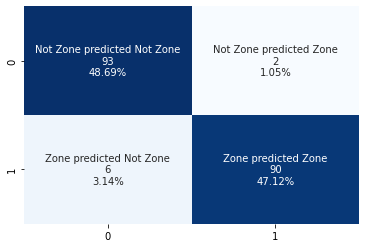

In [48]:
group_names = ['Not Zone predicted Not Zone', 'Not Zone predicted Zone', 'Zone predicted Not Zone', 'Zone predicted Zone']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False);

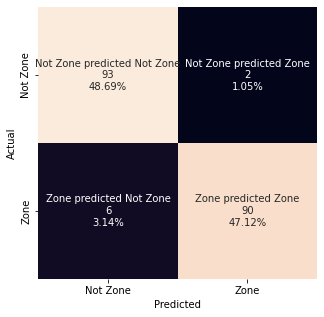

In [49]:
group_names = ['Not Zone predicted Not Zone', 'Not Zone predicted Zone', 'Zone predicted Not Zone', 'Zone predicted Zone']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(5,5));
sns.heatmap(cf_matrix, annot=labels, fmt='', xticklabels=['Not Zone', 'Zone'], yticklabels=['Not Zone', 'Zone'], cbar=False);
plt.ylabel('Actual');
plt.xlabel('Predicted');

In [50]:
def test_model(model, article):
    article_preprocessed = preprocess_text(article)
    article_preprocessed_1 = ' '.join([stemmer.stem(word) for word in article_preprocessed.split()])
    tfidf_article = tfidf_vectorizer.transform([article_preprocessed_1])
    prediction = model.predict(tfidf_article)
    if prediction[0] == 1:
        return 'Zone'
    return 'Not Zone'

In [51]:
# for i, j in zip(X_test, y_test):
#     if (test_model(vc, i)=='Zone' and j==0):
#         idx = data_preprocessed[data_preprocessed['article']==i]['id'].values[0]
#         print("====", idx, "====")
#         print(data[data['id']==idx]['article'].values[0])
#         print("/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/")

In [52]:
"""
    Not Zone predicted Zone
    1 try) 116 - 325 - 114
    2 try) 386 - 765 - 308 - 146
    3 try) 114 - 146
    4 try) 325 - 114 - 308 - 977 - 271 - 112 - 83 - 763 - 661 - 891
    5 try) 112 - 781 - 763 - 114
    6 try) 271 - 112 - 308 - 351 - 325 - 1131 - 386 - 763 - 83 - 146
    7 try) 146 - 114
    8 try) 1038 - 661 - 146 - 386 - 659
"""

'\n    Not Zone predicted Zone\n    1 try) 116 - 325 - 114\n    2 try) 386 - 765 - 308 - 146\n    3 try) 114 - 146\n    4 try) 325 - 114 - 308 - 977 - 271 - 112 - 83 - 763 - 661 - 891\n    5 try) 112 - 781 - 763 - 114\n    6 try) 271 - 112 - 308 - 351 - 325 - 1131 - 386 - 763 - 83 - 146\n    7 try) 146 - 114\n    8 try) 1038 - 661 - 146 - 386 - 659\n'

In [53]:
# for i, j in zip(X_test, y_test):
#     if (test_model(vc, i)=='Not Zone' and j==1):
#         idx = data_preprocessed[data_preprocessed['article']==i]['id'].values[0]
#         print("====", idx, "====")
#         print(data[data['id']==idx]['article'].values[0])
#         print("/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/")

In [54]:
"""
    Zone predicted Not Zone
    1 try) 261 - 1220 - 38 - 477 - 140 - 179 - 44 - 1040 - 292 - 229 - 528 - 731 - 
    101 - 665 - 138 - 71 - 92 - 1193 - 257 - 297
    2 try) 665 - 98 - 795 - 261 - 95 - 1100 - 226 - 212 - 127 - 1198 - 1196 -
    93 - 108 - 528 - 626 - 101 - 1193 - 1087 - 733 - 18 - 382 - 524 - 34
    3 try) 212 - 138 - 34 - 528 - 477 - 140 - 1087 - 101 - 44 - 95 - 297 - 292 -
    1220 - 71 - 301 - 142 - 1235 - 206 - 172 - 137 - 1198 - 98
    4 try) 1040 - 297 - 92 - 94 - 18 - 180 - 477 - 71 - 140 - 382 - 108 - 44 -
    229 - 1011 - 101 - 26 - 110 - 142 - 137 - 163 - 179 - 773 - 1198
    5 try) 179 - 127 - 301 - 94 - 34 - 370 - 477 - 1198 - 1040 - 38 - 142 - 459 -
    297 - 576 - 665 - 283 - 300 - 26
    6 try) 139 - 110 - 92 - 472 - 540 - 283 - 626 - 297 - 142 - 1235 - 627 -
    1040
    7 try) 540 - 297 - 93 - 44 - 172 - 646 - 33 - 212 - 140 - 180 - 95 - 1235 -
    517 - 206 - 1087 - 226 - 92 - 390 - 731
"""

'\n    Zone predicted Not Zone\n    1 try) 261 - 1220 - 38 - 477 - 140 - 179 - 44 - 1040 - 292 - 229 - 528 - 731 - \n    101 - 665 - 138 - 71 - 92 - 1193 - 257 - 297\n    2 try) 665 - 98 - 795 - 261 - 95 - 1100 - 226 - 212 - 127 - 1198 - 1196 -\n    93 - 108 - 528 - 626 - 101 - 1193 - 1087 - 733 - 18 - 382 - 524 - 34\n    3 try) 212 - 138 - 34 - 528 - 477 - 140 - 1087 - 101 - 44 - 95 - 297 - 292 -\n    1220 - 71 - 301 - 142 - 1235 - 206 - 172 - 137 - 1198 - 98\n    4 try) 1040 - 297 - 92 - 94 - 18 - 180 - 477 - 71 - 140 - 382 - 108 - 44 -\n    229 - 1011 - 101 - 26 - 110 - 142 - 137 - 163 - 179 - 773 - 1198\n    5 try) 179 - 127 - 301 - 94 - 34 - 370 - 477 - 1198 - 1040 - 38 - 142 - 459 -\n    297 - 576 - 665 - 283 - 300 - 26\n    6 try) 139 - 110 - 92 - 472 - 540 - 283 - 626 - 297 - 142 - 1235 - 627 -\n    1040\n    7 try) 540 - 297 - 93 - 44 - 172 - 646 - 33 - 212 - 140 - 180 - 95 - 1235 -\n    517 - 206 - 1087 - 226 - 92 - 390 - 731\n'

# Active learning:

In [374]:
#Read the data
unlabeled_data = pd.read_csv('FrArticle.csv', usecols=['Article'])#, usecols=['text','label'])

In [375]:
unlabeled_data.shape

(13992, 1)

In [376]:
unlabeled_data.columns = ['article']

In [377]:
unlabeled_data.head()

,article
0,Article premier La largeur des zones maritimes...
1,Article 3 Les eaux comprises dans les lignes d...
2,Article 4 Le présent décret sera publié au Jou...
3,Article 1: La largeur des eaux territoriales a...
4,Article 2 : A l’intérieur des eaux territorial...


In [378]:
unlabeled_data['article'] = unlabeled_data['article'].apply(lambda x: " ".join(x.strip().lower().split()))

In [379]:
data_to_annotate = pd.concat([data.drop(columns=['label', 'id']), unlabeled_data])

In [380]:
data_to_annotate.shape

(15264, 1)

In [381]:
data_to_annotate.drop_duplicates(keep=False, inplace=True)

In [382]:
data_to_annotate.shape

(8722, 1)

In [383]:
data_to_annotate['index'] = data_to_annotate.index

In [384]:
data_to_annotate.head()

,article,index
73,"article 1 : aux fins de la présente charte, on...",73
536,"article 9. - les centres régionaux, prévus ci-...",536
535,article 1. pour l'application du présent arrêt...,535
571,article 3eût exèrcer 18 pêche’ et la chasse au...,571
45,article 2. — le premier ministre est chargé de...,45


In [385]:
data_preprocessed_to_annotate = data_to_annotate.copy()

In [386]:
# data["article"] = data["article"].apply(lambda x: preprocess_text(x, remove_stopwords=True))
data_preprocessed_to_annotate["article"] = data_preprocessed_to_annotate["article"].apply(preprocess_text)
data_preprocessed_to_annotate.head(10)

,article,index
73,article fins pr sente charte entend a charte m...,73
536,article centres r gionaux pr vus ci dessus hab...,536
535,article application pr sent arr entend loi loi...,535
571,article e ex rcer p che chasse laring nivse li...,571
45,article premier ministre charg ex cution pr se...,45
290,article premier ins r code mer troisi partie a...,290
521,article exploitations peuvent avoir lieu zones...,521
391,article garde sceaux ministre justice ieminisl...,391
288,article er application articles ordonnance prg...,288
4,article base compte rendu reconnaissance fonct...,4


In [387]:
#Get shape
data_preprocessed_to_annotate.shape

(8722, 2)

In [388]:
stemmer = SnowballStemmer("french")
data_preprocessed_to_annotate['article'] = data_preprocessed_to_annotate['article'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

data_preprocessed_to_annotate.head(10)

,article,index
73,articl fin pr sent chart entend a chart mariti...,73
536,articl centr r gional pr vus ci dessus habil o...,536
535,articl appliqu pr sent arr entend loi loi janv...,535
571,articl e ex rcer p che chass laring nivs livr ...,571
45,articl premi ministr charg ex cution pr sent c...,45
290,articl premi in r cod mer trois part arr minis...,290
521,articl exploit peuvent avoir lieu zon contr se...,521
391,articl gard sceau ministr justic ieminislr aff...,391
288,articl er appliqu articl ordon prg mai port co...,288
4,articl bas compt rendu reconnaiss fonction gra...,4


In [389]:
#Get shape
data_preprocessed_to_annotate.shape

(8722, 2)

In [390]:
Classifiers = [('Logistic Regression', lr),
               ('XGBoost CLassifier', xgb),
#                ('Passive Aggressive Classifier', pac),
               ('Light GBM Classifier', lgb),
#                ('Ridge Classifier', ridge),
#                ('KNeighborsClassifier', knn),
               ('RandomForestClassifier', rfc),
#                ('SVC', svc),
#                ('SGDClassifier', sdgc),
#                ('DecisionTreeClassifier', dtreec),
               ('MultinomialNB', mnnb)
              ]

In [391]:
voting_classifier = VotingClassifier(estimators=Classifiers, voting='soft')

voting_classifier.fit(tfidf_train, y_train)
y_pred = voting_classifier.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Voting Classifier : {:}%".format(round(score*100, 2)))

Voting Classifier : 96.86%


In [392]:
def prob(model, article):
    article_preprocessed = preprocess_text(article)
    article_preprocessed = ' '.join([stemmer.stem(word) for word in article_preprocessed.split()])
    tfidf_article = tfidf_vectorizer.transform([article_preprocessed])
    prediction = model.predict_proba(tfidf_article)
    return [article, prediction[0][0], prediction[0][1]]

In [393]:
liste = []
for i in data_to_annotate['article']:
    liste.append(prob(voting_classifier, i))

In [394]:
len(liste)

8722

In [395]:
df = pd.DataFrame(liste)
df.columns = ['article', 'Not Zone', 'Zone']
df.head()

,article,Not Zone,Zone
0,"article 1 : aux fins de la présente charte, on...",0.943819,0.056181
1,"article 9. - les centres régionaux, prévus ci-...",0.886015,0.113985
2,article 1. pour l'application du présent arrêt...,0.901109,0.098891
3,article 3eût exèrcer 18 pêche’ et la chasse au...,0.888332,0.111668
4,article 2. — le premier ministre est chargé de...,0.914298,0.085702


In [402]:
df_high_labeled_zone = df[df['Zone'] >= 0.9][['article', 'Zone']]
df_high_labeled_not_zone = df[df['Not Zone'] >= 0.98][['article', 'Not Zone']]

In [403]:
df_high_labeled_zone.shape, df_high_labeled_not_zone.shape

((3, 2), (2, 2))

In [404]:
for index, row in df_high_labeled_zone.iterrows():
    print("Zone :", row["Zone"])
    print(row["article"])
    print("----------------------------------------------------------")
#     idx = random.randint(1, 20000)
#     while idx in dataset['id']:
#         idx = random.randint(1, 20000)
#     new_row = {'id':idx, 'article':row["article"], 'label':'Zone'}
#     dataset = dataset.append(new_row, ignore_index=True)

Zone : 0.9026148310614444
article 2. la délimitation de la zone visée à l'article 1°"" peut être décrite de la manière suivante :- à l'est, la frontière de la ville d'anvers en partant de la frontière nationale avec les pays-bas jusqu'aucroisement de la route régionale n49:- au sud, la route régionale n451, à partir du croisement précité jusqu'au croisement avec la route provincialen451;- à l'ouest, la route provinciale n451, à l'exception des zones résidentielles des communes de kieldrecht et deverrebroek et des terrains d'entreprises locaux situés le long de cette frontière occidentale;- au nord, la frontière nationale avec les pays-bas.2° l'article 3 est remplacé par ce qui suit :
----------------------------------------------------------
Zone : 0.9092856182996757
article 3. — dans sa zone économique exclusive, la république algérienne démocratique et populaire exerce sesdroits souverains et sa juridiction conformément auxdispositions de la convention des nations unies sur le droitd

In [399]:
dataset.shape

(1272, 3)

In [400]:
for index, row in df_high_labeled_not_zone.iterrows():
    print("Not Zone :", row["Not Zone"])
    print(row["article"])
    print("----------------------------------------------------------")
#     idx = random.randint(1, 20000)
#     while idx in dataset['id']:
#         idx = random.randint(1, 20000)
#     new_row = {'id':idx, 'article':row["article"], 'label':'Not Zone'}
#     dataset = dataset.append(new_row, ignore_index=True)

Not Zone : 0.9805061975360312
article 9. — i. — l’armateur constitue, conserve et tient à jour un dossier technique regroupant les informations relatives à la recherche et à l’identification des matériaux et produits faisant l’objet du présent décret ainsi qu’àl'évaluation de leur état de conservation.ce dossier précise la date, la nature, la localisation et les résultats des contrôles périodiques, des mesuresd’empoussièrement et, le cas échéant, des travaux effectués en application du présent décret.il — un exemplaire à jour du dossier est transmis au capitaine qui le tient a la disposition des membres del'équipage, du centre de sécurité des navires et de l’agent de contrôle de l’inspection du travail compétent.il — l’armateur communique ces informations à toute personne ou entreprise appelée à effectuer des travauxsur le navire.chapitre vsanctions pénales
----------------------------------------------------------
Not Zone : 0.982359217926627
article 12 : attribution du directeur. - l

In [401]:
dataset.shape

(1272, 3)

In [319]:
dataset.to_csv('OldData_and_newData.csv')